<a href="https://colab.research.google.com/github/predicthq/phq-data-science-docs/blob/master/academic-events/part_2_data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Academic Events Data Science Guides

# Part 2: Data Exploration

<b>A How To Guide to exploring PredictHQ Academic events data covering:</b>

 - [Setup](#setup)
 - [SDK or CSV Data Access](#csv_sdk)
 - [Event Time Series](#event_timeseries)
 - [Event Calendar](#event_calendar)
 - [Point Events and Area Events](#entity_locations)
 - [Off Campus Events](#off_campus)
 - [Attendance Distribution](#attendance)
 - [Rank Distribution](#rank)
 - [Duration](#duration)
 - [Session Type](#session_type)
 - [Estimates](#estimates)
 - [First Seen](#first_seen)
 - [Forecasting Impact](#forecasting_impact)


<a id='setup'></a>
## Setup

If using Google Colab uncomment the following code block.

In [105]:
# %%capture
# !git clone https://github.com/predicthq/phq-data-science-docs.git
# %cd phq-data-science-docs/academic-events
# !pip install predicthq>=1.6.3

If running locally, set up a Python environment using ```requirements.txt``` shared alongside the notebook to install the required dependancies.

In [106]:
import pandas as pd
import datetime
from datetime import timedelta

from geopy.distance import geodesic

from predicthq import Client

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

import sqlite3
import folium

from folium import plugins, FeatureGroup, Marker, Popup, Tooltip, Circle
from folium.plugins import HeatMap

<a id='csv_sdk'></a>
## SDK or CSV Data Access

This notebook can be run using both the csv example data provided, or if you have access to the PredictHQ Events Endpoint, you can use the code provided to call the SDK for the locations of interest to you. 

The starting point for Part 2 is the dataset created at the end of Part 1. As using the SDK is not the focus of Part 2, a function is created to call the SDK. For guidance on how to use the SDK, refer to Part 1. 

In [107]:
def extract_matching_label(event_labels, labels_to_match):
    ''' For each event labels need to be
    extracted. These labels are extracted from the labels.
    As the order of the labels varies this look up is
    required to compare to the frozenset of options.
    '''
    for label in labels_to_match:
        if label in event_labels:
            return label
    return None


SUB_CATEGORY = frozenset([
                          'academic-session',
                          'exam',
                          'graduation',
                          'holiday',
                          'social',
                          ])

SESSION_TYPE = frozenset([
                          'online-session',
                          'hybrid-session',
                         ])

ESTIMATED = frozenset([
                      'estimated',
                      ])


def extract_entity_name(row):
    '''The entity represents the venue of the event
    The name of the entity is required'''
    if len(row['entities']) > 0:
        return row['entities'][0]['name']
    else:
        return None

In [108]:
def query_location_academic_radius(lat_long, radius, start, end, timezone='UTC'):
    '''Function to query the sdk based on a lat_long
    Replicates the process in Part 1. Could be adjusted
    to use a place id instead.
    Default timezone to utc.
    Implements basic data preparation.
    
    '''

    # Define API parameters.
    parameters_dict = dict()

    parameters_dict.update(active__gte=start, active__lte=end)
    parameters_dict.update(active__tz=timezone)
    parameters_dict.update(category=['academic'])
    parameters_dict.update(limit=500)
    parameters_dict.update(within='{}mi@{},{}'.format(radius,
                                                     lat_long[0],
                                                     lat_long[1]))  

    search_results = phq.events.search(parameters_dict).iter_all()

    search_results = [result.to_dict() for result in search_results]

    df = pd.DataFrame(search_results)

    df['entity_name'] = df.apply(extract_entity_name, axis=1)

    df[['longitude', 'latitude']] = pd.DataFrame(df.location.tolist())

    # Create a list of unique entities.
    df_entities = df.drop_duplicates('entity_name')
    df_entities = df_entities[['entity_name',
                               'latitude',
                               'longitude']]

    df['sub_category'] = df.labels.apply(extract_matching_label,
                                         args=(SUB_CATEGORY, ))
    df['session_type'] = df.labels.apply(extract_matching_label,
                                         args=(SESSION_TYPE, ))
    df['estimated'] = df.labels.apply(extract_matching_label,
                                      args=(ESTIMATED, ))

    # fill non-specified session_type with in-person
    df['session_type'].fillna('in-person', inplace=True)
    # fill non-specified estimated with scheduled
    df['estimated'].fillna('not_estimated', inplace=True)

    # Where events are missing attendance fill with 0. 
    # PredictHQ aims to have attendance for all events. 
    # This assumption can be changed depending on your use case. (mean by subcategory or location)
    df['phq_attendance'].fillna(0, inplace=True)

    # If holiday then off campus
    df.loc[df['sub_category'] == 'holiday', 'on_campus'] = False

    df['on_campus'].fillna(True, inplace=True)

    return df

## Example Locations

In [109]:
# Set whether to run with SDK or using provided CSV files
# Set to either 'CSV' or 'SDK'
RUN_SETTING = 'CSV'

# If using RUN_SETTING = 'CSV' update CURRENT_PLACENAME and PLACE_ID
# If using RUN_SETTING = 'SDK' update ACCESS_TOKEN, CURRENT_PLACENAME, LAT_LONG, RADIUS, START_DATE and END_DATE

# Austin 
PLACE_ID = 4671654
CURRENT_PLACENAME = 'Austin Texas'
LAT_LONG = ['30.2785', '-97.7395']
# Los Angeles
PLACE_ID = 5368361
CURRENT_PLACENAME = 'Los Angeles'
LAT_LONG = ['34.0778', '-118.3602']
# Chicago
# PLACE_ID = 4887398
# CURRENT_PLACENAME = 'Chicago'
# LAT_LONG = ['41.8048', '-87.5871']
# Tallahassee Florida 
# PLACE_ID = 4174715
# CURRENT_PLACENAME = 'Tallahassee Florida'
# LAT_LONG = ['30.4420', '-84.2845']


START_DATE = '2019-01-01'
END_DATE = '2021-01-01'
# default unit in notebook is miles
RADIUS = 20

ACCESS_TOKEN = '<REPLACE WITH YOUR ACCESS TOKEN HERE>'
phq = Client(access_token=ACCESS_TOKEN)

In [145]:
# Executes either the function to call the SDK or loads in the data from CSV.

if RUN_SETTING == 'SDK':
    # If timezone known specify timezone. 
    df = query_location_academic_radius(lat_long=LAT_LONG,
                                 radius=RADIUS,
                                 start=START_DATE,
                                 end=END_DATE
                                 )

elif RUN_SETTING == 'CSV':
    START_DATE = '2019-01-01'
    END_DATE = '2021-01-01'
    
    df = pd.read_csv('data/place_ids_{}_{}_{}.csv'
                     .format(PLACE_ID,
                             START_DATE,
                             END_DATE))

    # Format local_start_datetime to datetime
    df['start'] = pd.to_datetime(df['start'])
    df['first_seen'] = pd.to_datetime(df['first_seen'])
else:
    print("Must set RUN_SETTING to either 'SDK' or 'CSV'")

In [146]:
# The following functions provide some additional analysis. 
# They identify if the event has a separate related main campus. 

def find_home_campus(row, df_entities):
    '''Find if any of the entities are mentioned in the event title
    If the entity is mentioned in the title add this as the main
    campus'''
    for key, entities in df_entities.iterrows():
        if str(entities['entity_name']) in row['title']:
            row['main_campus'] = entities['entity_name']
            row['main_latitude'] = entities['latitude']
            row['main_longitude'] = entities['longitude']
            return row
        else:
            row['main_campus'] = None
            row['main_latitude'] = None
            row['main_longitude'] = None
    return row


def calculate_distance_to_main_campus(row):
    '''Calculate the distance between the location
    of the event and the main campus'''
    cols = ['latitude',
            'longitude',
            'main_latitude',
            'main_longitude']
    if row[cols].notnull().all():
        origin = (row['latitude'], row['longitude'])
        main = (row['main_latitude'], row['main_longitude'])
        row['distance_main_campus'] = (geodesic(origin,
                                                main).miles)
    else:
        row['distance_main_campus'] = None
    return row

df_entities = df.drop_duplicates('entity_name')
df_entities = df_entities[['entity_name',
                               'latitude',
                               'longitude']]

df = df.apply(find_home_campus, args=(df_entities, ), axis=1)
df = df.apply(calculate_distance_to_main_campus, axis=1)

<a id='event_timeseries'></a>
## Event Time Series

Event times are returned in UTC. You may chose to convert these for this visualisation if making more granular insights.

In [147]:
# Round down to the day start
# This means the first day will be included in the join.
df['start_floor'] = df['start'].dt.floor('D')

# To create data at the daily level
# First create a list of days between the start_date and end_date
start = datetime.datetime.strptime(START_DATE + ' 00:00:00',
                                   "%Y-%m-%d %H:%M:%S")
end = datetime.datetime.strptime(END_DATE,
                                 "%Y-%m-%d")
diff = end - start
# Calculate the total number of days between start_date and end_date
days = diff.days
date_list = [start + timedelta(days=x) for x in range(int(days))]
# Create new dataframe using the list.
df_daily = pd.DataFrame({'daily_breakdown': date_list})
# Convert to time aware. Use UTC as start and end are in UTC.
df_daily['daily_breakdown'] = pd.to_datetime(df_daily['daily_breakdown'],
                                             utc=True)

df_academic = df[['id',
                  'title',
                  'start',
                  'start_floor',
                  'end',
                  'timezone',
                  'duration',
                  'category',
                  'latitude',
                  'longitude',
                  'rank',
                  'phq_attendance',
                  'sub_category',
                  'entity_name',
                  'main_campus',
                  'session_type',
                  'estimated',
                  'on_campus']].copy()

# Use SQL to allow simple BETWEEN join.
conn = sqlite3.connect(':memory:')
# create the tables
df_daily.to_sql('daily', conn, index=False)
df_academic.to_sql('academic', conn, index=False)

# This query will match each academic event to all the days is is on.

query = '''
    SELECT
    *
    FROM
    daily LEFT JOIN academic
    ON
    daily.daily_breakdown BETWEEN academic.start_floor AND academic.end
'''

df_daily = pd.read_sql_query(query, conn)

# Group by each day and take the sum
aggregated_daily = (
       df_daily.groupby(['sub_category',
                         'daily_breakdown'],
                        )
               .agg(
                     total_attendance=('phq_attendance', 'sum')
                    )
               .reset_index()
                )
# Convert title to different columns
df_day = pd.pivot_table(aggregated_daily,
                        values='total_attendance',
                        index=['daily_breakdown'],
                        columns=['sub_category'],
                        aggfunc='sum',
                        fill_value=0)

df_day.reset_index(inplace=True)

When COVID-19 restrictions were implemented part way through an academic session a covid class cancellation holiday was created to 
account for the mid session shutdowns.
These cancellations occur between approximately March and September 2020. Post September 2020, the impact of covid is managed by
a reduced academic session attendance figure. 

If COVID-19 Class Cancellation are not removed from the holidays category they can cause double counting of holidays.
If they are disguarded, attendance figures for academic sessions in March to September 2020 are likely too high.
For events in this period the whole event attendance can not be adjusted because for part of the session students were present. 

The data provides you with the option to manage this in different ways depending on your usecase.

The following section provides code to adjust the attendance of academic sessions occuring at the same time as a covid cancellation holiday to 0. 
The covid holidays are then disguarded. 

In [148]:
# Separate the covid cancellation events
covid_cancellations = df_daily[df_daily['title'] == 'COVID-19 Class Cancellation'].copy()[['daily_breakdown', 'phq_attendance', 'entity_name']]
# Separate the social, graduation and holidays - these will not be updated by covid cancellations.
df_holidays_social_graduations = df_daily.loc[(df_daily['sub_category'] != 'academic-session')
                                               & (df_daily['sub_category'] != 'exam') 
                                               & (df_daily['title'] != 'COVID-19 Class Cancellation')]

# Remove the covid cancellations
df_daily = df_daily[df_daily['title'] != 'COVID-19 Class Cancellation'].copy()
                
# Combine the days where there is a covid cancellation and an exam or academic. 
df_daily_covid_adj = df_daily.loc[(df_daily['sub_category'] == 'academic-session')
                         | (df_daily['sub_category'] == 'exam')
                         ].merge(covid_cancellations,
                            how='left',
                            left_on=['daily_breakdown', 'entity_name'],
                            right_on=['daily_breakdown', 'entity_name'],
                            suffixes=('','_covid_cancellation'))

df_daily_covid_adj['phq_attendance_covid_cancellation'].fillna(0, inplace=True)
# Update attendance to be zero for academic session where there was a covid cancellation.
df_daily_covid_adj.loc[(df_daily_covid_adj['phq_attendance_covid_cancellation'] > 0), 'phq_attendance'] = 0

df_daily_covid_adj.reset_index(inplace=True)
df_holidays_social_graduations.reset_index(inplace=True)
# Concatenate back on the other categories. 
df_daily_covid_adj = pd.concat([df_daily_covid_adj, df_holidays_social_graduations], ignore_index=True)

In [149]:
# Group by each day and take the sum
aggregated_daily_covid_adjusted = (
       df_daily_covid_adj.groupby(['sub_category',
                         'daily_breakdown'],
                        )
               .agg(
                     total_attendance=('phq_attendance', 'sum')
                    )
               .reset_index()
                )
# Convert title to different columns
df_day_covid_adjusted = pd.pivot_table(aggregated_daily_covid_adjusted,
                        values='total_attendance',
                        index=['daily_breakdown'],
                        columns=['sub_category'],
                        aggfunc='sum',
                        fill_value=0)

df_day_covid_adjusted.reset_index(inplace=True)

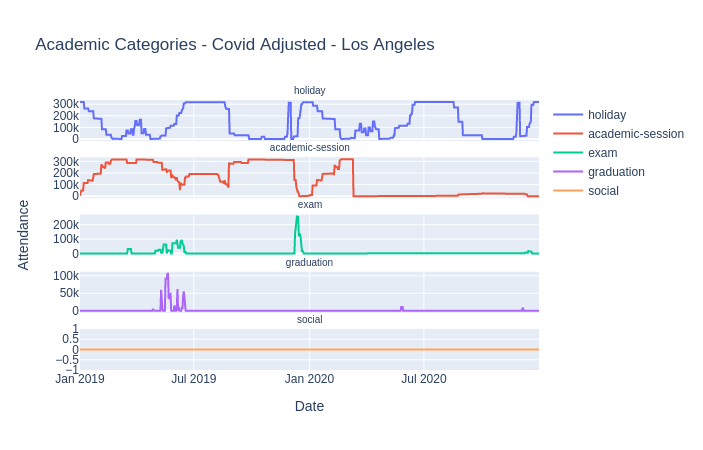

In [150]:
sub_categories = df['sub_category'].unique()

fig = make_subplots(rows=len(sub_categories),
                    cols=1,
                    shared_xaxes=True,
                    vertical_spacing=0.06,
                    subplot_titles=(sub_categories))

row = 1
for category in sub_categories:
    fig.add_trace(go.Scatter(x=df_day_covid_adjusted['daily_breakdown'], y=df_day_covid_adjusted[category],
                             mode='lines',
                             name=category), row=row, col=1)

    row = row + 1

fig.update_layout(
                  title_text="Academic Categories - Covid Adjusted - {}"
                  .format(CURRENT_PLACENAME)
                  )
for i in fig['layout']['annotations']:
    i['font'] = dict(size=10)

fig.update_yaxes(title_text="Attendance", row=int(row/2))
fig.update_xaxes(title_text="Date", row=row-1)

Graduation, exam and social represent more sparse data. Events are fewer and shorter in duration.

Academic and holidays represent longer duration events and tend to have opposite behaviour. When there is large holiday attendance, academic attendance is lower and vice versa. 

The physical attendance of an academic session is notably effected by COVID-19 restrictions in most locations.

Looking further into the future, events start to reduce as calendar dates are unavailable. 

The academic sessions and exam for a specific institution do not overlap. 

<a id='entity_locations'></a>
## Point Events and Area Events

All of the Academic Events have an associated entity with an associated latitude and longitude point location. 

Graduation and social events occur at those point locations. For academic-session, holidays and exams, a point location is provided but in reality the event and attendance applies to the whole campus.

For example if an academic session has an attendance of 10,000 and lasts for 3 months, the attendance can not be thought of as being concentrated at that location. Instead it represents that 10,000 students are present on campus during that time. 


- An entity represents the physcial location of the event.
- In the following visual:
    - Social and graduations are shown as point locations.
    - Academic-sessions, holidays and exams are shown as circles around a point.
    - The circles are shown with radius of 3km.
    - 3km is chosen to represent the most likely area of impact for these events.
    - The radius size can be changed depending on location, campus and use case. 
    - Different radial sizes will likely suit different locations. 
    - Different event types can be selected in the right hand menu.

For forecasting, these events can be treated as point locations. It is more important to consider this when chosing the radius of interest around your location. A location might be much closer to the area of impact than a point location would suggest. 

In [151]:
map = folium.Map(location=[float(LAT_LONG[0]), float(LAT_LONG[1])],
                 zoom_start=9)

colors = ['red', 'green', 'blue', 'black', 'orange']
for i, sub_category in enumerate(df['sub_category'].unique()):
    df_temp = df[df['sub_category'] == sub_category]
    feature_group = FeatureGroup(name=sub_category)

    for index, row in df_temp.iterrows():
        feature_group.add_child(Marker([row['latitude'],
                                        row['longitude']],
                                tooltip=Tooltip(row['entity_name']),
                                icon=folium.Icon(color=colors[i])))

        if sub_category in ['academic-session', 'holiday', 'exam']:
            feature_group.add_child(Circle([row['latitude'],
                                            row['longitude']],
                                    # radius unit is in meters       
                                    radius=3000,
                                           )
                                    )

    map.add_child(feature_group)
    
map.add_child(folium.map.LayerControl())

map

In [152]:
df_non_holidays = df_daily_covid_adj[ \
                        df_daily_covid_adj['sub_category'] != 'holiday'] \
                        .copy()

aggregated_daily = (
       df_non_holidays.groupby(['latitude',
                                'longitude'],
                               )
                      .agg(
                     total_attendance=('phq_attendance', 'sum')
                    )
                       .reset_index()
                    )

In [153]:
m = folium.Map(location=[float(LAT_LONG[0]), float(LAT_LONG[1])],
                    zoom_start=9)

heat_data = [[row['latitude'],
              row['longitude'],
              row['total_attendance']] for index,
              row in aggregated_daily.iterrows()]

HeatMap(heat_data, radius=30).add_to(m)
m

The weights applied to this heatmap are the sum of the phq_attendance across all days the events occur. 
The weighting therefore implies the location where across the time period you have the most impact. For example this means that an event of 1000 attendance that goes on for 100 days will have a greater color density than a location with a one day event of 50000 people. 
You might chose to implement other versions of this heatmap that look at the maximum attendance at an entity location. 

<a id='off_campus'></a>
## Off Campus Events

Some events are associated with a specific educational institution but are held off campus. For example a graduation event might be held away from the usual campus location.


In [154]:
cols = ['title',
        'latitude',
        'longitude',
        'entity_name',
        'main_campus',
        'main_latitude',
        'main_longitude',
        'distance_main_campus']

In [155]:
# % Are calulcated to be at a location > 2 miles from the main campus
percent_off_campus = round(((len(df[(~df['main_campus'].isna()) &
                                    (df['distance_main_campus'] > 2)]))
                            / len(df))*100,
                           2
                           )
print('{} % of events are calculated to be occuring at a location that is > 2 miles from the main campus'.format(percent_off_campus))

0.18 % of events are calculated to be occuring at a location that is > 2 miles from the main campus


### Example of Event Away from Main Campus

Only executed if there are any examples of events that are related to an academic institution whose main campus is further than 2 miles away from the event venue.

In [156]:
# Test to see if for this example there are any off main campus events.
# Only graph off main campus events if there are any.
if df['distance_main_campus'].max() > 2:
    df_grouped = df[~df['main_campus'].isna()
                    & (df['distance_main_campus'] > 2)].\
                            groupby('main_campus', as_index=False).count()

    df_grouped.sort_values('category', inplace=True, ascending=False)
    df_grouped.reset_index(inplace=True, drop=True)

    df_one = df[df['main_campus'] == df_grouped['main_campus'][0]].copy()
    df_one.sort_values('distance_main_campus', ascending=False)
    df_one.reset_index(inplace=True, drop=True)
    df_one[['title',
            'entity_name',
            'main_campus',
            'distance_main_campus',
            ]]

    m = folium.Map(location=[float(LAT_LONG[0]), float(LAT_LONG[1])],
                   zoom_start=9)

    folium.Marker(
        location=[df_one.loc[0]['latitude'], df_one.loc[0]['longitude']],
        tooltip=Tooltip('Event Location: ' + df_one.loc[0]['entity_name']),
        icon=folium.Icon(color="blue", icon="info-sign"),
    ).add_to(m)
    folium.Marker(
        location=[df_one.loc[0]['main_latitude'],
                  df_one.loc[0]['main_longitude']],
        tooltip=Tooltip('Main Campus: ' + df_one.loc[0]['main_campus']),
        icon=folium.Icon(color="red", icon="info-sign"),
    ).add_to(m)
    display(m)
    
    print(df_one[['title', 'main_campus','entity_name', 'distance_main_campus']])

                                          title               main_campus  \
0  Los Angeles City College - Spring Graduation  Los Angeles City College   

         entity_name  distance_main_campus  
0  The Greek Theatre              2.234475  


In this notebook off campus refers only to holidays.
 
These events that occur away from the main campus could also be thought of as off campus for the main campus. 
 
Events occuring away from the main campus still have a positive impact on the specific location of the event, but may have a negative impact on the main campus location. The interpretation of this will be highly dependent on your use case. In the instance, where your demand is heavily impacted by on campus activity you might want to associate a negative impact to events occuring away from the main campus as these may draw away students.

Events occuring away from the main campus tend to be related to graduations.

In [157]:
# Group by each day and take the sum
on_campus_daily = (
       df_daily_covid_adj.groupby(['on_campus',
                         'daily_breakdown'],
                        )
               .agg(
                       total_attendance=('phq_attendance', 'sum')
                   )
               .reset_index()
                      )
# Convert title to different columns
df_day_campus = pd.pivot_table(on_campus_daily,
                               values='total_attendance',
                               index=['daily_breakdown'],
                               columns=['on_campus'],
                               aggfunc='sum',
                               fill_value=0)

df_day_campus.reset_index(inplace=True)

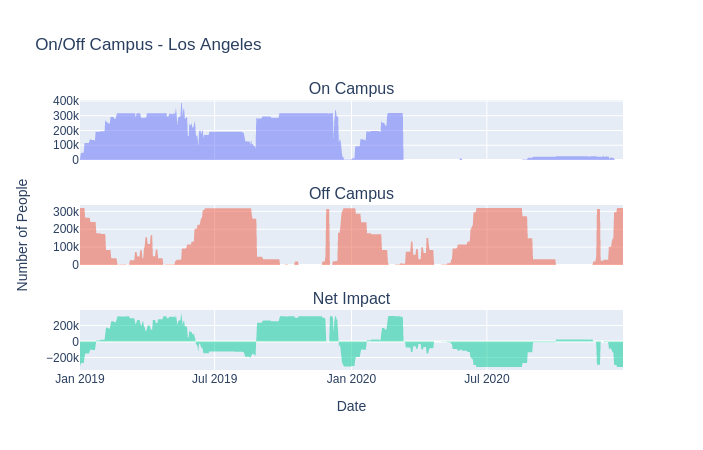

In [158]:
# on_campus minus offcampus
df_day_campus['net_positive_on_campus'] = (df_day_campus[1.0]
                                           - df_day_campus[0.0])
fig = make_subplots(rows=3,
                    cols=1,
                    shared_xaxes=True,
                    start_cell="top-left",
                    horizontal_spacing=0.08,
                    subplot_titles=(['On Campus',
                                     'Off Campus',
                                     'Net Impact']))

fig.add_trace(go.Scatter(x=df_day_campus['daily_breakdown'],
                         y=df_day_campus[1.0],
                         fill='tozeroy',
                         mode='none'
                         ),
              row=1,
              col=1)

fig.add_trace(go.Scatter(x=df_day_campus['daily_breakdown'],
                         y=df_day_campus[0.0],
                         fill='tozeroy',
                         mode='none'
                         ),
              row=2,
              col=1)

fig.add_trace(go.Scatter(x=df_day_campus['daily_breakdown'],
                         y=df_day_campus['net_positive_on_campus'],
                         fill='tozeroy',
                         mode='none'
                         ),
              row=3,
              col=1)

fig.update_layout(showlegend=False)
fig.update_layout(
    title_text="On/Off Campus - {}".
    format(CURRENT_PLACENAME)
                  )

fig.update_xaxes(title_text="Date",
                 row=3,
                 col=1)
fig.update_yaxes(title_text="Number of People",
                 row=2,
                 col=1)
fig.show()

By interpreting off campus events as a negative attendance, off campus and on campus events can be combined to create the net impact of events.

These graphs represent the whole location and not necessarily one campus. They therefore show the net effect of all students from all institutions in that area.

The same analysis could be carried out on a smaller location where the end result actually relates to one campus. 

We advise using separate features for events rather than the net impact. This is because holidays and academic sessions can overlap. For example the Fall Break will occur within the Fall Session. There will be no break within the Fall Session event when the Fall Break occurs.  

## Group By Academic Institution

In [159]:
df_daily_covid_adj['main_campus'].fillna(df_daily_covid_adj['entity_name'], inplace=True)

In [160]:
top_5 = df.groupby('main_campus', as_index=False) \
    .agg({'phq_attendance': 'max'}) \
        .sort_values('phq_attendance', ascending=False) \
            .head(5)['main_campus']

top_5 = list(top_5)

In [161]:
df_daily_covid_adj['phq_attendance_weighted'] = df_daily_covid_adj['phq_attendance']
# weighted attendance is negative if off campus and positive if on campus.
df_daily_covid_adj.loc[df_daily_covid_adj['on_campus'] == 0,
              'phq_attendance_weighted'] = -1 * df_daily_covid_adj['phq_attendance_weighted']

In [162]:
# Group by each day and take the sum
on_campus_daily = (
       df_daily_covid_adj.groupby(['main_campus',
                         'daily_breakdown'],
                        )
               .agg(
                       net_attendance=('phq_attendance_weighted', 'sum')
                   )
               .reset_index()
                      )
# Convert title to different columns
df_day_campus = pd.pivot_table(on_campus_daily,
                               values='net_attendance',
                               index=['daily_breakdown'],
                               columns=['main_campus'],
                               aggfunc='sum',
                               fill_value=0)

df_day_campus.reset_index(inplace=True)

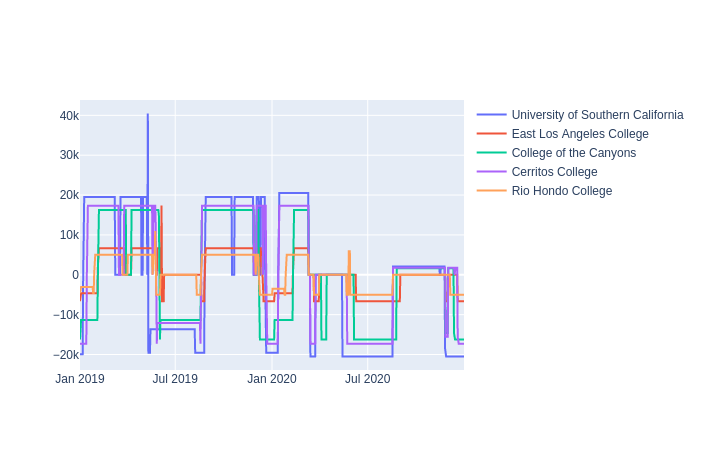

In [163]:
# Create traces
fig = go.Figure()

for top_institution in top_5: 
    fig.add_trace(go.Scatter(x=df_day_campus['daily_breakdown'],
                             y=df_day_campus[top_institution],
                        mode='lines',
                        name=top_institution))

fig.show()


In [164]:
# Set to your preferred institution 
INSTITUTION = top_5[0]

In [165]:
df_one_institution = df_daily_covid_adj[
        (df_daily_covid_adj['entity_name'] == INSTITUTION)
        | (df_daily_covid_adj['main_campus'] == INSTITUTION)
                                        ]

In [166]:
# Group by each day and take the sum
aggregated_daily = (
       df_one_institution.groupby(['sub_category',
                         'daily_breakdown'],
                        )
               .agg(
                     total_attendance=('phq_attendance', 'sum')
                    )
               .reset_index()
                )
# Convert title to different columns
df_one_institution = pd.pivot_table(aggregated_daily,
                        values='total_attendance',
                        index=['daily_breakdown'],
                        columns=['sub_category'],
                        aggfunc='sum',
                        fill_value=0)

df_one_institution.reset_index(inplace=True)

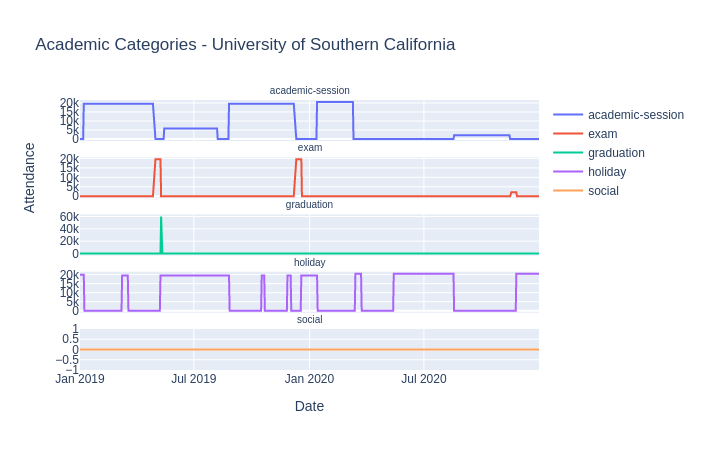

In [167]:
sub_categories = list(df_one_institution.columns)
sub_categories.remove('daily_breakdown') 

fig = make_subplots(rows=len(sub_categories),
                    cols=1,
                    shared_xaxes=True,
                    vertical_spacing=0.06,
                    subplot_titles=(sub_categories))


for row, category in enumerate(sub_categories, start=1):
    fig.add_trace(go.Scatter(x=df_one_institution['daily_breakdown'],
                             y=df_one_institution[category],
                             mode='lines',
                             name=category), row=row, col=1)

fig.update_layout(
                  title_text="Academic Categories - {}"
                  .format(INSTITUTION)
                  )
for i in fig['layout']['annotations']:
    i['font'] = dict(size=10)

fig.update_yaxes(title_text="Attendance",
                 row=int(row/2))
fig.update_xaxes(title_text="Date", row=row)

Holidays can occur within an academic session. For example, the Fall Break will occur within the Fall Session. There will be no break within the Fall Session event when the Fall Break occurs. Exam sessions are separate to the main academic sessions. 

 <a id='attendance'></a>
## Attendance Distribution

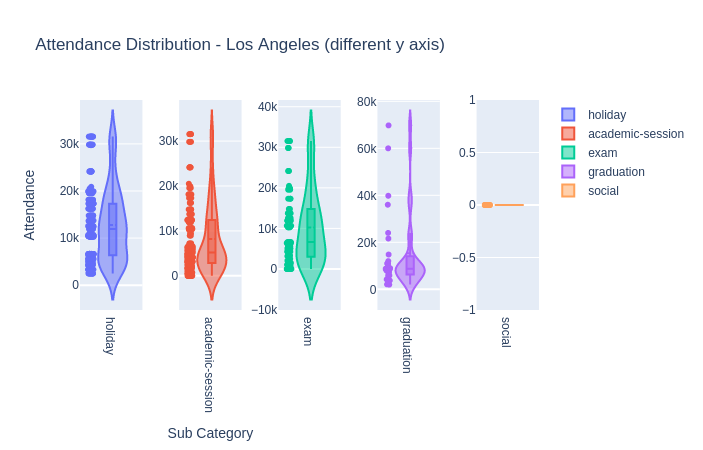

In [168]:
col = 1
sub_categories = df['sub_category'].unique()

fig = make_subplots(rows=1,
                    cols=len(sub_categories),
                    start_cell="top-left",
                    horizontal_spacing=0.08)

# Plot each sports league on separate axis.
for sub_category in sub_categories:

    x_data = df['sub_category'][df['sub_category'] == sub_category]
    y_data = df['phq_attendance'][df['sub_category'] == sub_category]
    fig.add_trace(go.Violin(x=x_data,
                            y=y_data,
                            name=sub_category,
                            box_visible=True,
                            meanline_visible=True),
                  row=1,
                  col=col,
                  )
    fig.update_xaxes(tickangle=90, row=1, col=col)
    col = col + 1

fig.update_traces(meanline_visible=True,
                  points='all',
                  jitter=0.2,
                  scalemode='count')

fig.update_layout(
    title_text="Attendance Distribution - {} (different y axis)".
    format(CURRENT_PLACENAME)
                  )

fig.update_xaxes(title_text="Sub Category",
                 row=1,
                 col=int(len(sub_categories)/2))
fig.update_yaxes(title_text="Attendance",
                 row=1,
                 col=1)
fig.show()


These distribution plots can extraplote misleading values when there are few data points. Hence the actual data points are plotted against the violin plots to avoid misinterpretation. 


Social and graduation events can also have some of the highest attendance values. This is because they often include family members or alumni on top of the current student population. 

<a id='rank'></a>
## Rank Distribution

- No local rank
- No aviation rank

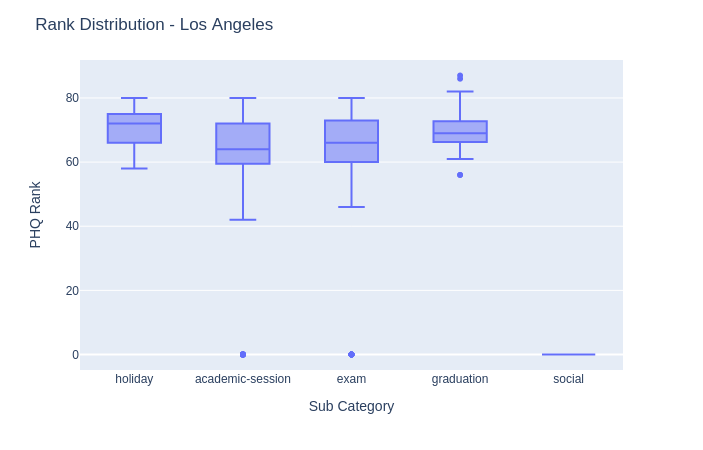

In [170]:
fig = px.box(df, x="sub_category", y="rank")

fig.update_layout(
    title_text="Rank Distribution - {}".
    format(CURRENT_PLACENAME)
)

fig.update_xaxes(title_text="Sub Category",
                 row=1,
                 col=1)
fig.update_yaxes(title_text="PHQ Rank",
                 row=1,
                 col=1)
fig.show()

Rank for social and graduation is impacted by the cases where social and graduation do not have a predicted attendance. 

Rank for academic-session, holiday and exam are fairly consistant. This is because attendance is based largely on the student numbers at each institution which is then consistent across holidays, exams and academic-sessions.

<a id='duration'></a>
## Duration

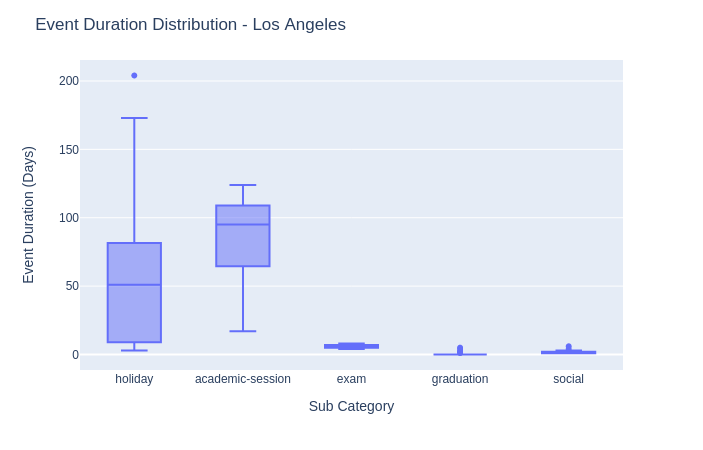

In [171]:
df['duration_days'] = df['duration']/(60*60*24)
fig = px.box(df, x="sub_category", y="duration_days")
fig.update_layout(
    title_text="Event Duration Distribution - {}".
    format(CURRENT_PLACENAME)
)

fig.update_xaxes(title_text="Sub Category",
                 row=1,
                 col=1)
fig.update_yaxes(title_text="Event Duration (Days)",
                 row=1,
                 col=1)
fig.show()

Apart from graduation, durations are all more than 1 day in length.

<a id='session_type'></a>
## Session Type

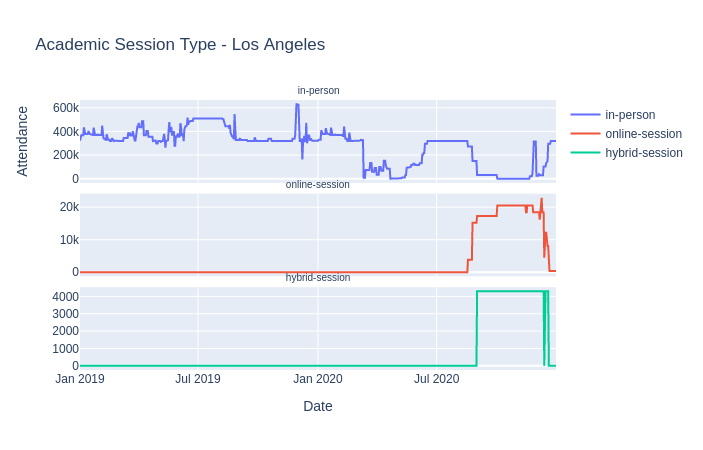

In [172]:
# Group by each day and take the sum
session_type_daily = (
       df_daily_covid_adj.groupby(['session_type',
                         'daily_breakdown'],
                        )
               .agg(
                       total_attendance=('phq_attendance', 'sum')
                   )
               .reset_index()
                      )
# Convert title to different columns
df_day_session = pd.pivot_table(session_type_daily,
                                values='total_attendance',
                                index=['daily_breakdown'],
                                columns=['session_type'],
                                aggfunc='sum',
                                fill_value=0)

df_day_session.reset_index(inplace=True)

session_types = df['session_type'].unique()

fig = make_subplots(rows=len(session_types),
                    cols=1,
                    shared_xaxes=True,
                    vertical_spacing=0.04,
                    subplot_titles=(session_types))


for row, session in enumerate(session_types, start=1):
    fig.add_trace(go.Scatter(x=df_day_session['daily_breakdown'],
                             y=df_day_session[session],
                             mode='lines',
                             name=session),
                  row=row,
                  col=1)


fig.update_layout(
    title_text="Academic Session Type - {}".format(CURRENT_PLACENAME)
    )
for i in fig['layout']['annotations']:
    i['font'] = dict(size=10)

fig.update_yaxes(title_text="Attendance", row=int(row/2))
fig.update_xaxes(title_text="Date", row=row)

Remember that the attendance numbers for online-sessions and hybrid-sessions still represent physical attendance numbers. 

<a id='estimates'></a>
## Estimates 


In [173]:
df_daily_covid_adj.loc[df_daily_covid_adj['estimated'] == 'estimated', 'estimated_binary'] = 1
df_daily_covid_adj['estimated_binary'].fillna(0, inplace=True)

df_estimates = (
       df_daily_covid_adj.groupby(['sub_category',
                         'daily_breakdown'],
                        )
                .agg(
                    count=('id', 'count'),
                    estimates=('estimated_binary', 'sum')
                    )
                .reset_index()
                )

# Convert title to different columns
df_estimates = pd.pivot_table(df_estimates,
                              values='estimates',
                              index=['daily_breakdown'],
                              columns=['sub_category'],
                              aggfunc='sum',
                              fill_value=0)

df_estimates.reset_index(inplace=True)

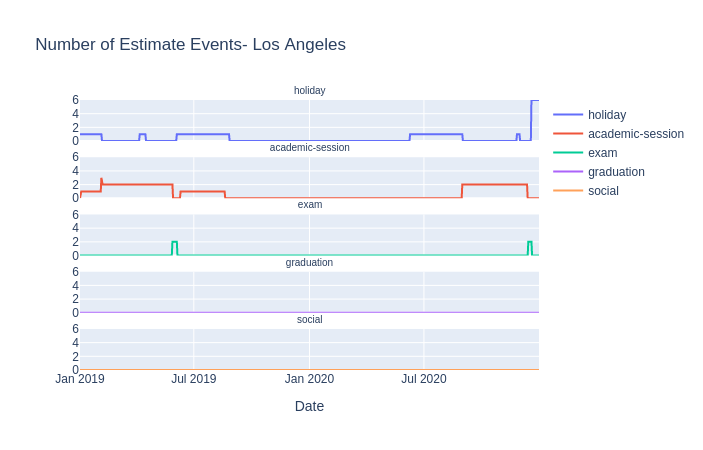

In [175]:
fig = make_subplots(rows=len(df['sub_category'].unique()),
                    cols=1,
                    shared_xaxes=True,
                    vertical_spacing=0.06,
                    subplot_titles=(df['sub_category'].unique()))

for row, category in enumerate(df['sub_category'].unique(), start=1):
    fig.add_trace(
        go.Scatter(
                   x=df_estimates['daily_breakdown'],
                   y=df_estimates[category],
                   name=category
                  ),
        row=row,
        col=1)

fig.update_layout(
    title_text="Number of Estimate Events- {}".format(CURRENT_PLACENAME)
)
for i in fig['layout']['annotations']:
    i['font'] = dict(size=10)
fig.update_xaxes(title_text="Date", row=row)

fig.update_yaxes(range=[0,
                        df_estimates[df['sub_category'].unique()]
                        .max().max()])

fig.update_yaxes(title_text="Number of Estimate Events", row=row/2)

fig.show()

<a id='first_seen'></a>
## First Seen

PredictHQ released our Academic Events category in 2020.

Althought the distribution of first seen implies we did not know about a large number of events before the event, the reason for this is that when we designed the category we filled in historic event information to provide historic training data for forecasting models. To more fairly represent this, the below diagram only looks at events that started in 2021 or later. If your date range does not include data after January 2021 no figure will show. 

For this category events will be known in advance when academic calendars are released. 

To increase provision of events ahead of their scheduled date, events will also be estimated.


In [176]:
df['seen_before'] = df['start'] - df['first_seen']
df['seen_before'] = df['seen_before'].dt.days

# only show dates after January 2021
# to avoid showing dates before category was launched.
df_post_2020 = df[df['start'] >= '2021-01-01']

if len(df_post_2020) > 0:
    fig = px.box(df_post_2020, x='sub_category', y="seen_before")

    fig.update_layout(
        title_text="Number Days Before Event Included in Data - {}"
        .format(CURRENT_PLACENAME)
    )

    fig.update_xaxes(title_text="Sub Category")
    fig.update_yaxes(title_text="Days Included Before Event")

    fig.show()

The majority of academic events are added to our system between ~150 and 300 days in advance.

<a id='forecasting_impact'></a>
## Forecasting Impact

Within this notebook we've gained a better understanding of PredictHQ Academic Events data, what it represents and how it behaves. 

With this in mind we can take these findings and inform the decisions we make in forecasting. 

Here's a summary of some of the key take-ways from each section. 

- <b>Event Time Series</b><br>
Academic sessions, holidays and exams are events of longer duration.
- <b>Event Calendar</b><br>
Holidays and academic sessions mostly occur at alternate times. 
- <b>Point Events and Area Events</b><br>
    Socials and graduations occur at the point locations of the entities listed. For academic sessions, holidays and exams the events affect an area around campus. 
- <b>Off Campus Events</b><br>
    Holidays represent students leaving campus and can be thought of as off campus. Other off campus events are events where the events location is away from the main campus. This can result in students been drawn away from the campus location. In this case you can get a positive attendance impact at the location but also a negative impact at the main campus.
- <b>Attendance Distribution</b><br>
  Attendance is fairly static across academic sessions, exams and holidays as these numbers represent the overall student body. Socials and graduations can actually have larger attendance numbers because as well as students, families and alumni attend. 
- <b>Duration</b><br>
  Social and graduation are much shorter events.
- <b>Session Type</b><br>
  Hybrid and online sessions are already accounted as the phq attendance still represents the physical attendees.
- <b>Estimates</b><br>
  Some events are estimated.
- <b>First Seen</b><br>
  When looking at first seen it should be noted that this category was only created for the US in 2020 and Europe in 2021. Historic events are therefore often first seen after their start date as the events were back populated. Future events are usually populated for the academic year ahead. 